In [7]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 5
which_mode= 'hbarstreamf' # global heat flux

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'hbarstreamf'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None
ref_name  = None # None
ref_year  = None # [1979,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 25
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
which_dpi = 300
do_rescale= False
proj      = 'pc'
ncolumn   = 3

In [9]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac  
if climit   is not None: cinfo['climit']=climit  
if chist    is not None: cinfo['chist' ]=chist
if ctresh   is not None: cinfo['ctresh']=ctresh    
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    


 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node.pckl
 > comp. e_resol from mean
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/


In [10]:
datapath = input_paths[0]
#___________________________________________________________________________
# load information about edges 
fname = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

# load diag file
meshdiag = xr.open_dataset(os.path.join(dname,fname))
# node indices of edge points [2 x n2ded]
edge     =meshdiag['edges'].values-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
edge_tri =meshdiag['edge_tri'].values-1
# dx & dy of edge midpoints towards element centroid of left and right triangle
edge_dxdy=meshdiag['edge_cross_dxdy'].values[:]

# dx & dy of left triangle --> norm vector 
edge_dxdy_l=np.array([ edge_dxdy[1,:], -edge_dxdy[0,:]])
# dx & dy of right triangle --> norm vector 
edge_dxdy_r=np.array([-edge_dxdy[3,:],  edge_dxdy[2,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist


In [11]:
#______________________________________________________________________________________________________
# create zonal and meridional bins
dlon, dlat,  = 1.0, 1.0
lon  = np.arange(-180, 180+dlon, dlon)
lat  = np.arange(-90 ,  90+dlat, dlat)

#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if ref_path is not None:
    print(ref_path, ref_name)
    #__________________________________________________________________________________________________
    # load u,v data
    data = tpv.load_data_fesom2(mesh, ref_path, vname='vec+u+v', year=ref_year, descript=ref_name, 
                                    do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False)
    
    #__________________________________________________________________________________________________
    # compute  horizontal barotropic streamfunction by binning
    hbstreamf_ref = tpv.calc_hbarstreamf(mesh, data, lon, lat, edge, edge_tri, edge_dxdy_l, edge_dxdy_r)
    del data

#___LOAD FESOM2 DATA___________________________________________________________________________________
hbstreamf_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    #__________________________________________________________________________________________________
    # load u,v data
    data = tpv.load_data_fesom2(mesh, datapath, vname='vec+u+v', year=year, descript=descript, 
                                    do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False)
    
    #__________________________________________________________________________________________________
    # compute  horizontal barotropic streamfunction by binning
    hbstreamf = tpv.calc_hbarstreamf(mesh, data, lon, lat, edge, edge_tri, edge_dxdy_l, edge_dxdy_r)
    del data
    if ref_path is not None:
        hbstreamf = hbstreamf - hbstreamf_ref
        hbstreamf[list(hbstreamf.keys())[0]].attrs['long_name'] = '{:s} {:s}'.format('anomalous',hbstreamf[list(hbstreamf.keys())[0]].attrs['long_name'])
    hbstreamf_list.append(hbstreamf)
    
    

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/ TKE


{'cstr': 'blue2red', 'cnum': 25, 'cref': 0, 'chist': True, 'ctresh': 0.995}
--> histo: cmin, cmax =  -41.56585271348463 170.58478341698225
{'cstr': 'blue2red', 'cnum': 25, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -41.57, 'cmax': 170.58, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fce8c27bc50>, 'clevel': array([-45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,   5.,
        10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,
        65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115.,
       120., 125., 130., 135., 140., 145., 150., 155., 160., 165., 170.,
       175.])}


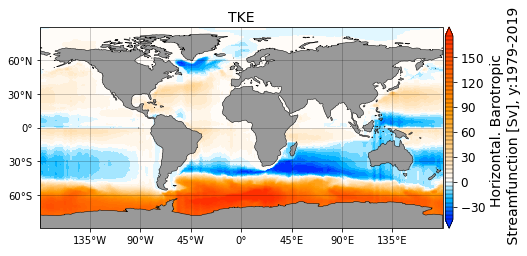

In [12]:
# #___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(hbstreamf_list[0].keys())[0]
slabel = hbstreamf_list[0][sname].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
if save_fname is not None: spath = save_fname
ncolumn= np.min([ncolumn,len(hbstreamf_list)])    
nrow   = np.ceil(len(hbstreamf_list)/ncolumn).astype('int')
pos_gap= [0.005, 0.04]
if proj in ['nps, sps']:pos_gap = [0.005, 0.035]     
print(cinfo)    
fig, ax, cbar = tpv.plot_hbstreamf(mesh, hbstreamf_list, input_names, cinfo=cinfo, box=box, n_rc=[nrow, ncolumn], 
                            figsize=[ncolumn*7, nrow*3.5], proj = proj, 
                            do_rescale=do_rescale, title='descript', 
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi)